# Plotting 2D Gradient Vector Field of Electrostatic Density 

## Introduction
This notebook is meant to visualize the 2 dimensional gradient vector field of the electronic density of the provided molecule

## Dependencies

1. numpy
2. matplotlib 
3. Chemtools 

## Obtaining XYZ coordinates

We use the chemtools call `mol.coordinates` to obtain the XYZ cartesian coordinates of our molecule, in this example, dichloropyrimidine. 

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Need this to plot in 3D

from chemtools import Molecule

mol = Molecule.from_file("dichloropyridine26_q+0.fchk")
# mol = Molecule.from_file('acrolein_q+0.fchk')
coord = mol.coordinates

print("XYZ Coordinates: ")
print(coord)

print(" ")
print("Atomic Numbers Each Atom: ")
print(mol.numbers)

Initialized: <horton.gbasis.cext.GOBasis object at 0x7f2af0d82360>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     3 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     4 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     5 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     6 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     7 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     8 :  S3 S1 S1 P1 P1
  Center     9 :  S3 S1 S1 P1 P1
  Center    10 :  S3 S1 S1 P1 P1

XYZ Coordinates: 
[[-4.95130924e+00  2.31173977e+00 -2.64561659e-04]
 [ 4.95149821e+00  2.31139962e+00  2.07869875e-04]
 [ 7.55890453e-05  1.84250188e+00 -1.88972613e-05]
 [-9.44863066e-05 -3.41775868e+00  1.13383568e-04]
 [-2.28277027e+00 -2.09580077e+00 -1.88972613e-05]
 [ 2.28267578e+00 -2.09595195e+00  1.70075352e-0

## Rotate and Scale Operation

We wish to force the molecular to be planar, we accomplish this using numpy's linear algebra capabilities, more specifically rotation and scaling operations. 

First, we use `np.cross()` to perform a cross product and `np.linalg.norm()` on our coordinates to generate an orthonormal set. 

Then, we have to perform our rotation operation
```
cos(x)) + a^2 * (1-cos(x)      a*u*(1-cos(x)      u*sin(x)

a * u *(1-cos(x))           cos(x) + u^2 *(1-cos(x))   -a *sin(x)

-u * sin(x)                 a * sin(x)              cos(x) 
```



In [126]:
v1, v2 = coord[1] - coord[0], molCoord[2] - coord[0]
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])


## Plot our rotated coordinates

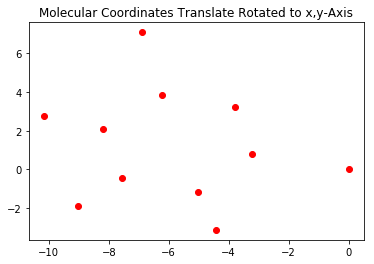

In [127]:
rot_coords = np.dot(rot, (coord - coord[0]).T).T

# ERROR: THIS ASSERTION TEST FAILS
#assert np.all(np.abs(rot_coords[:, 2]) < 1e-5)  # Make sure the z-axis is zero.
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro")
plt.title("Molecular Coordinates Translate Rotated to x,y-Axis")
plt.show()

## Generate a Grid

To eventually plot our gradient vector field, we must initialize a "grid" with several points.

[-11.15737795  -4.13120126  -1.00005684]


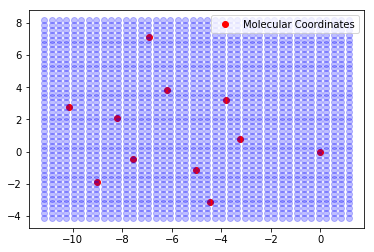

In [128]:
l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1
print(l_bnd)
step_size = 0.3
x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)

plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.plot(grid_2d[:, 0], grid_2d[:, 1], "bo", alpha=0.25)
plt.legend()
plt.show()


## Generating a Corresponding Affine Plane

We now must plot our coordinates on the grid plane generated below

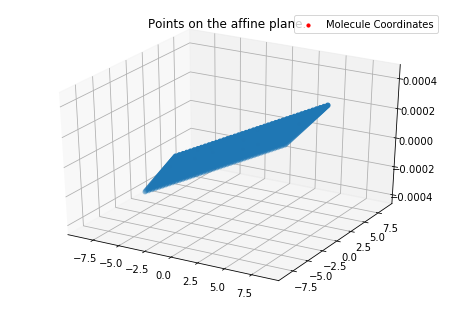

In [129]:
# Add zero z-axis and rotate it and translate it to the plane
grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
assert np.all(np.abs(np.dot(grid_plane, normal)) < 1e-5)
grid_plane += coord[0]


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(grid_plane[:, 0], grid_plane[:, 1], grid_plane[:, 2])
ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], c="r", s=10,
           label="Molecule Coordinates")
plt.legend()
plt.title("Points on the affine plane.")
plt.show()

## Computing Gradient and Plotting  the Gradient Vector Field 

The gradient vector is a column vector of the partial derivative of each variable in a system. In the context of electron density of a molecule, the gradient vectors will become increasingly positive as one approaches individual atoms or functional groups that have a higher electrostatic potential, such as halogens or carboxylic acids.

### Computing

We use Chemtools `compute_gradient()` function on our input molecule and our previously generated grid plane to create our gradient vectors

We then to perform a projection, which is the dot product of the computed gradients and the orthonormal vectors subtracted from the computed gradient vectors.

### Plotting

We wish to visualize this in 2 dimensional cartesian space, shich is accomplished by performing the dot product on our projection (`proj_gradients`) and our orthonormal vector. 



In [130]:
gradients = mol.compute_gradient(grid_plane)


proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)
# Rotate the projected gradients onto two-dimensions.
rot_proj_gradients = np.dot(rot, proj_gradients.T).T
assert np.all(np.abs(rot_proj_gradients[:, 2]) < 1e-8)

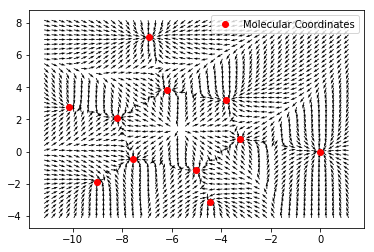

In [131]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1], scale=50)
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()

In [118]:
#plt.contour(rot_coords[:,0], rot_coords[:, 1], 2